# VGG-16 Model with Data Augmentation Techniques

*Conv2D, Dense, Flatten, Input, MaxPooling2D are extracted from tensorflow.keras.layers. These are the layers which are used to build the neural networks* <br> *plot_model is from tensorflow.keras.utils. This function is used to visualize the neural network model architecture* <br> *train_test_split from sklearn.model_selection:  This is used to split the dataset into training and testing sets.
compute_class_weight from sklearn.utils is used to calculate weights for the classes when dealing with imbalanced datasets.*

In [3]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import backend as K
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, losses, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

# Loading the CSV File

*pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv"), this line reads a CSV file located at this specified path into a Pandas DataFrame called folds* <br> *pd.DataFrame(folds.iloc[:7909]), this creates a new DataFrame df that contains only the first 7909 rows of the original folds DataFrame.* <br> *df['label'].str.strip(): This removes any leading or trailing whitespace characters from each entry in the label column.*

In [6]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])

In [7]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df['label'] = df['label'].str.strip()

# Creating the Bar Plot

*x="label" this pecifies that the label column in the df DataFrame will be used for the x-axis, representing the different categories in this case it is benign and malignant.* <br> *data=df, defines that the df DataFrame is the source of the data.* <br> *kind="count": Specifies that this is a count plot, which automatically counts the occurrences of each category in the label column.* <br> *hue="label": Adds a hue dimension to the plot, different colors will be used for different categories in the label column.* <br> *legend=False This will Disable the legend, which would otherwise display what each color represents.*

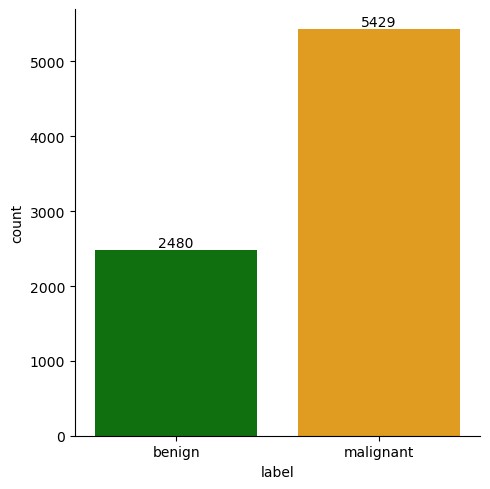

In [10]:
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
plt.show()

# Converting Categorical Labels to Integer Labels

*apply(lambda x: ['benign', 'malignant'].index(x)), the apply function is used to apply a lambda function to each element in the label column.* 

In [13]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

*train_test_split(): This function is from sklearn.model_selection this splits the data into training and testing sets.* <br> 
*test_size=0.2, this specifies that 20% of the data should be used as the test set, and the remaining 80% as the training set.* <br> 
*random_state=42, this ensures that the split is reproducible. The random_state parameter seeds the random number generator used to shuffle the data before splitting. By setting it to 42, it ensures that every time we run the code, we get the same train-test split.*

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

# parse_image Function <br>
*tf.io.read_file(path) This function reads the contents of the file located at the above provided path. The result of this is a raw byte string.* <br> *tf.image.decode_png(img, channels=3), this decodes the raw byte string into a PNG image. The channels=3 argument specifies that the image should be decoded as a 3-channel (RGB) image, even if the original image is grayscale or has an alpha channel.* <br>
*return img, label this returns the decoded image along with its associated label. This is important for keeping the image and its label together as they pass through the preprocessing stage.* <br> <br>
# resize_rescale Function <br>
*tf.cast(image, tf.float32), this converts the image pixel values to float32* <br> *tf.image.resize(img, [64, 64]) / 255.0 This line
resizes the image to 64x64 pixels. It is done ensures that all images have the same dimensions, which is necessary for feeding them into a neural network.* <br> *Divides by 255.0 to normalize the pixel values to the range [0, 1] (since the original pixel values range from 0 to 255). Normalizing inputs, helps to stabilize and speed up the learning process.* <br> *return img, label, returns the resized and rescaled image along with its label.* <br> <br>
# augment_image Function <br>
*tf.image.random_flip_left_right(image), this function randomly flips the image horizontally (left-to-right). This helps the model to learn that the object is being classified and might appear in different orientations.* <br> *tf.image.random_flip_up_down(image), this function randomly flips the image vertically (upside-down). Similar to horizontal flipping, this helps the model to learn from different orientations.* <br> *tf.image.random_brightness(image, max_delta=0.1, this function randomly adjusts the brightness of the image. The max_delta=0.1 parameter controls the maximum change in brightness. This simulates different lighting conditions.* <br> *tf.image.random_contrast(image, lower=0.9, upper=1.1), this function randomly adjusts the contrast of the image. The lower=0.9 and upper=1.1 parameters control the range of possible contrast adjustments, simulating varying contrast levels in the image.* 

In [17]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [224, 224]) / 255.0  
    return img, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Creating TensorFlow Datasets from Tensor Slices

In [19]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test, y_test))

# Applying augmentation and preprocessing it to the training dataset

*train_loader, this is the Dataset object that was created at first, containing tuples of image paths and labels for the training data.* <br>
*X_trainset: This dataset is ready for training a model. It includes images that have been augmented (here augmentation is used to introduce variability) resized, normalized, shuffled, and batched.* <br> *X_testset, this dataset is ready for testing the model. It includes images that have been resized, normalized, and batched, but not augmented*

In [22]:
# Applying data augmentation to the training dataset
X_trainset = train_loader.map(parse_image).map(augment_image).map(resize_rescale).shuffle(len(X_train)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
X_testset = test_loader.map(parse_image).map(resize_rescale).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Figure for Plotting

*plt.figure(figsize=(15, 15)) creates a new figure for plotting, with a specified size of 15x15 inches.* <br> X_trainset.take(9) this takes the first 9 elements (images and labels) from the X_trainset dataset. <br> *for i, (img, label) in enumerate(), this loop iterates over these 9 elements. i is the loop index, img is the image tensor, and label is the corresponding label tensor.* <br> *ax = fig.add_subplot(3, 3, i+1),this creates a 3x3 grid of subplots within the figure. The i+1 specifies the position of the current subplot in the grid (since i is zero-based, i+1 makes it one-based).*

2024-08-17 03:00:44.171373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3172 of 6327
2024-08-17 03:00:54.172313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 6213 of 6327
2024-08-17 03:00:54.534558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 03:00:54.800337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


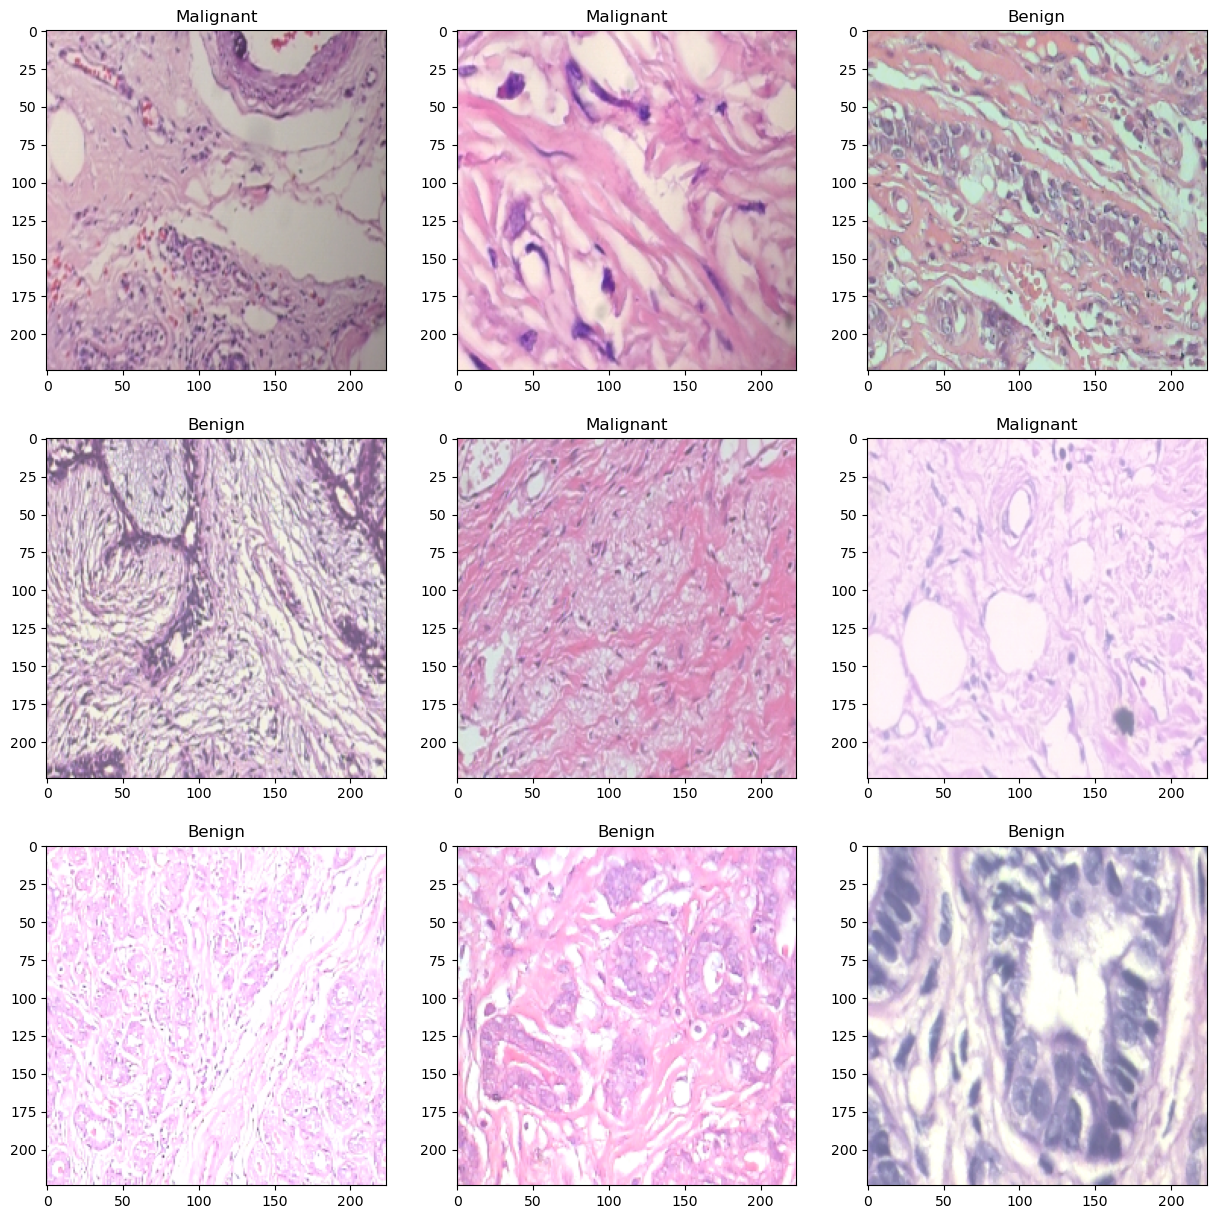

In [25]:
# Displaying the sample images
fig = plt.figure(figsize=(15, 15))
for images, labels in X_trainset.take(1):
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1)
        if labels.numpy()[i] == 0:
            ax.title.set_text("Benign")
        else:
            ax.title.set_text("Malignant")
        plt.imshow(images.numpy()[i])
plt.show()

# Defining the Input Shape, Building the Model, Compiling the Model and Visualizing the Model Summary, Transfer Learning with VGG16

# Setting the Input Shape <br>
*img_shape = (224, 224, 3), this variable defines the shape of the input images. 224, 224 defines the images are 224x224 pixels.* <br> <br>
# Loading the Pre-trained VGG16 Model <br>
*VGG16(include_top=False, weights='imagenet', input_shape=input_shape)* <br>
*include_top=False, this Excludes the fully connected layers at the top of the network (the original classifier part of VGG16). This is how we use VGG16 model as a feature extractor.* <br>
*weights='imagenet', This function loads the weights that were pre-trained on the ImageNet dataset, which contains millions of images across thousands of categories. This enables the model to leverage the rich features learned during pre-training.* <br>
*input_shape=input_shape, specifies the shape of the input images that the model will process.* <br> <br>
# Freezing the Base Model <br>
*base_model.trainable = False, this freezes the layers of the VGG16 base model so that their weights are not updated during training.* <br><br>
# Building the Custom Model <br>
*base_model, the VGG16 model is added as the first part of the model, serving as a feature extractor.* <br> *GlobalAveragePooling2D(), A pooling layer that reduces the spatial dimensions of the feature maps from the base model, producing a single vector for each feature map.*
*Dense(64, activation="relu"), A fully connected (dense) layer with 64 units and ReLU activation function. This is used to add complexity and allows the model to learn non-linear relationships in the data.* <br> *Dense(64, activation="relu"), another dense layer with 64 units and ReLU activation, adding further depth and capacity to the model.* <br> *Dense(2, activation="softmax"), this is the output layer with 2 units, corresponding to the two classes also softmax activation function is used to output probabilities for each class.* <br> <br>
# Compiling the Model <br>
*optimizer="adam", this function uses the Adam optimizer, which adapts the learning rate during training, making it efficient for many problems.* <br> *loss="sparse_categorical_crossentropy", this specifies the loss function to be minimized. In this case, it's used for multi-class classification problems where labels are provided as integers (not one-hot encoded).* <br> *metrics=["accuracy"], specifies that accuracy should be tracked during training and evaluation.* <br> <br>
# Building the Model <br>
*model.build(input_shape=(None, 224, 224, 3)), this explicitly builds the model by specifying the input shape, ensuring that the model is ready for training.* <br> <br>
# Displaying the Model Summary
*model.summary(), this function prints a summary of the model architecture, showing each layer, its output shape, and the number of parameters used*

In [28]:
# Defining the model using VGG16
input_shape = (224, 224, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Freezing the base model

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, 224, 224, 3))  # Ensuring that the model is built before calling summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,751,810 (56.27 MB)

 Trainable params: 37,122 (145.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Visualizing the Model Training Performance: Accuracy and Loss Over Epochs

*history.history['accuracy'] is a list of accuracy values for the training data across each epoch.* <br> *history.history['val_accuracy'], this is a list of accuracy values for the validation data* <br> *ax1.plot(), this plots the validation accuracy over epochs on the same subplot ax1.* <br> *ax1.set_title('Accuracy'), this sets the title of the subplot to "Accuracy".* <br> *ax1.set_ylabel('Accuracy score') this labels the y-axis as "Accuracy score".* <br> *ax1.set_xlabel('Epoch'), this labels the x-axis as "Epoch".* <br> *ax1.legend(), this adds a legend to ax1 to distinguish between the training and validation accuracy lines.* <br> <br> *history.history['loss'] is a list of loss values for the training data across each epoch.* <br> *ax2.plot(label='train'), plots the training loss over epochs on ax2, the second subplot. This line is labeled as 'train' for the legend.* <br> *history.history['val_loss'], this is a list of loss values for the validation data.* <br> *ax2.plot(label='validation'), plots the validation loss over epochs on the same subplot ax2.* <br> *ax2.set_title('Loss'), sets the title of the subplot to "Loss".* <br> *ax2.set_ylabel('Loss'), labels the y-axis as "Loss".* <br> *ax2.set_xlabel('Epoch'), labels the x-axis as "Epoch".* <br> *ax2.legend(), this adds a legend to ax2 to distinguish between the training and validation loss lines.*

In [31]:
def plotTrainingHistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('The Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

# Computing Class Weights <br>
*compute_class_weight, this function calculates weights for each class based on their frequency in the training data to handle class imbalance.* <br> *Dictionary Creation, this converts the array of class weights into a dictionary where each class label is mapped to its corresponding weight.* <br> *This is done to ensure that the model treats all classes fairly during training, even when some classes are underrepresented in the dataset.* <br> <br> 
# Implementing Early Stopping and Training with Class Weights <br>
*monitor="val_loss",this metric is used to monitor during training. In this, it monitors the validation loss (val_loss).* <br>
*mode="min", specifies that the training should stop when the val_loss has stopped decreasing (i.e, when it has reached a minimum).* <br>
*patience=5, this parameter defines how many epochs the model should wait after the last improvement in validation loss before stopping. If the validation loss does not improve for 5 consecutive epochs, training will stop.* <br> *restore_best_weights=True, after stopping, the model's weights are restored to the values from the epoch where the validation loss was at its best. This ensures that the model returns to its best state before overfitting began.* <br> *verbose=1, this function controls the verbosity of the training output. A value of 1 means progress will be printed for each epoch.* <br> *plotTrainingHistory(history), this function plots the accuracy and loss of the model over the training epochs for both the training and validation sets.* <br> <br>
# Generating and Comparing Predictions on the Test Set <br>
*model.predict(X_testset), this function runs the trained model on the test dataset (X_testset) and generates predictions for each input sample.* <br> *tf.argmax(y_test_pred, axis=1), tf.argmax is a TensorFlow function that returns the index of the maximum value along a specified axis.* <br> *axis=1, specifies that the function should look at each row (each prediction) in y_test_pred and find the index of the highest probability. Since the model output represents probabilities for two classes that is 0 for benign and 1 for malignant, tf.argmax returns 0 if the first probability is higher and 1 if the second probability is higher.* <br> *predicted_categories, this variable stores the predicted class labels (either 0 or 1) for each sample in the test set.* <br> *true_categories, this variable contains the true class labels for all samples in the test set, combined into one tensor.* <br> <br>
# Evaluating Model Performance with Classification Report and Confusion Matrix <br>
*classification_report, A function from sklearn.metrics that generates a text report showing the main classification metrics: precision, recall, F1-score, and support.* <br> *true_categories, the true class labels from the test set.* <br> *predicted_categories, the class labels predicted by the model.* <br> *target_names=["Benign", "Malignant"], this assigns the names "Benign" and "Malignant" to the class labels 0 and 1, respectively.* <br> 
*confusion_matrix(true_categories, predicted_categories, normalize='true')* <br> *Here, normalize='true', normalizes the confusion matrix by dividing each entry by the sum of the true instances for each class.* <br> *Conf_mat is used to store the resulting normalized confusion matrix.* <br> *sns.heatmap(conf_mat, annot=True, fmt='.4g'), Here sns.heatmap is a function from Seaborn, it is a data visualization library that creates a heatmap from the confusion matrix.* 

Epoch 1/25


2024-08-17 03:01:06.449566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3046 of 6327
2024-08-17 03:01:17.123300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 812s 8s/step - accuracy: 0.5767 - loss: 0.6632 - val_accuracy: 0.6068 - val_loss: 0.6459
Epoch 2/25


2024-08-17 03:14:38.343374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2846 of 6327
2024-08-17 03:14:48.350623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5602 of 6327
2024-08-17 03:14:51.228032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 918s 9s/step - accuracy: 0.7239 - loss: 0.5433 - val_accuracy: 0.7857 - val_loss: 0.4618
Epoch 3/25


2024-08-17 03:29:55.973325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2657 of 6327
2024-08-17 03:30:05.977801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5330 of 6327
2024-08-17 03:30:09.801543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 979s 10s/step - accuracy: 0.7834 - loss: 0.4587 - val_accuracy: 0.8287 - val_loss: 0.3991
Epoch 4/25


2024-08-17 03:46:14.725214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2459 of 6327
2024-08-17 03:46:29.991027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 985s 10s/step - accuracy: 0.8111 - loss: 0.4158 - val_accuracy: 0.8173 - val_loss: 0.4083
Epoch 5/25


2024-08-17 04:02:39.660844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2643 of 6327
2024-08-17 04:02:53.354321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 982s 10s/step - accuracy: 0.8074 - loss: 0.4152 - val_accuracy: 0.8635 - val_loss: 0.3497
Epoch 6/25


2024-08-17 04:19:01.329623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2624 of 6327
2024-08-17 04:19:15.587862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 942s 9s/step - accuracy: 0.8264 - loss: 0.3885 - val_accuracy: 0.8534 - val_loss: 0.3651
Epoch 7/25


2024-08-17 04:34:43.065535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2625 of 6327
2024-08-17 04:34:53.066310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5345 of 6327
2024-08-17 04:34:56.686650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 946s 9s/step - accuracy: 0.8231 - loss: 0.3875 - val_accuracy: 0.7364 - val_loss: 0.5275
Epoch 8/25


2024-08-17 04:50:28.857318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2676 of 6327
2024-08-17 04:50:42.331182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 936s 9s/step - accuracy: 0.8266 - loss: 0.3840 - val_accuracy: 0.8571 - val_loss: 0.3421
Epoch 9/25


2024-08-17 05:06:05.047042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2639 of 6327
2024-08-17 05:06:18.899297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 951s 9s/step - accuracy: 0.8441 - loss: 0.3500 - val_accuracy: 0.8565 - val_loss: 0.3423
Epoch 10/25


2024-08-17 05:21:55.906965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2463 of 6327
2024-08-17 05:22:11.274792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 987s 10s/step - accuracy: 0.8468 - loss: 0.3355 - val_accuracy: 0.8319 - val_loss: 0.3721
Epoch 11/25


2024-08-17 05:38:23.277938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2389 of 6327
2024-08-17 05:38:38.786587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1026s 10s/step - accuracy: 0.8479 - loss: 0.3479 - val_accuracy: 0.8679 - val_loss: 0.3167
Epoch 12/25


2024-08-17 05:55:29.161692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2624 of 6327
2024-08-17 05:55:39.163557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5233 of 6327
2024-08-17 05:55:43.340003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 976s 10s/step - accuracy: 0.8539 - loss: 0.3386 - val_accuracy: 0.8641 - val_loss: 0.3180
Epoch 13/25


2024-08-17 06:11:44.874016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2624 of 6327
2024-08-17 06:11:59.073176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 996s 10s/step - accuracy: 0.8599 - loss: 0.3217 - val_accuracy: 0.8198 - val_loss: 0.3909
Epoch 14/25


2024-08-17 06:28:21.206565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2600 of 6327
2024-08-17 06:28:35.380260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 977s 10s/step - accuracy: 0.8595 - loss: 0.3196 - val_accuracy: 0.8793 - val_loss: 0.3082
Epoch 15/25


2024-08-17 06:44:38.243742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2590 of 6327
2024-08-17 06:44:48.246159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5222 of 6327
2024-08-17 06:44:52.590671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 992s 10s/step - accuracy: 0.8618 - loss: 0.3129 - val_accuracy: 0.8736 - val_loss: 0.3026
Epoch 16/25


2024-08-17 07:01:09.895756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2572 of 6327
2024-08-17 07:01:19.897299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5110 of 6327
2024-08-17 07:01:24.687179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 986s 10s/step - accuracy: 0.8676 - loss: 0.2988 - val_accuracy: 0.8831 - val_loss: 0.2834
Epoch 17/25


2024-08-17 07:17:36.042729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2579 of 6327
2024-08-17 07:17:46.045251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5117 of 6327
2024-08-17 07:17:50.621776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 975s 10s/step - accuracy: 0.8623 - loss: 0.3080 - val_accuracy: 0.8862 - val_loss: 0.2780
Epoch 18/25


2024-08-17 07:33:50.838327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2589 of 6327
2024-08-17 07:34:00.843755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5206 of 6327
2024-08-17 07:34:05.194560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 952s 9s/step - accuracy: 0.8781 - loss: 0.2925 - val_accuracy: 0.8919 - val_loss: 0.2776
Epoch 19/25


2024-08-17 07:49:42.663807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2674 of 6327
2024-08-17 07:49:56.183905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 929s 9s/step - accuracy: 0.8857 - loss: 0.2688 - val_accuracy: 0.8913 - val_loss: 0.2753
Epoch 20/25


2024-08-17 08:05:11.976776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2676 of 6327
2024-08-17 08:05:21.983744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5421 of 6327
2024-08-17 08:05:25.387857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 935s 9s/step - accuracy: 0.8824 - loss: 0.2729 - val_accuracy: 0.8982 - val_loss: 0.2645
Epoch 21/25


2024-08-17 08:20:47.190125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2620 of 6327
2024-08-17 08:21:01.183811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 957s 9s/step - accuracy: 0.8852 - loss: 0.2619 - val_accuracy: 0.8862 - val_loss: 0.2652
Epoch 22/25


2024-08-17 08:36:44.167660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2674 of 6327
2024-08-17 08:36:58.381041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 972s 10s/step - accuracy: 0.8775 - loss: 0.2888 - val_accuracy: 0.8843 - val_loss: 0.2787
Epoch 23/25


2024-08-17 08:52:55.933405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2663 of 6327
2024-08-17 08:53:09.631026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 934s 9s/step - accuracy: 0.8951 - loss: 0.2430 - val_accuracy: 0.8616 - val_loss: 0.3177
Epoch 24/25


2024-08-17 09:08:30.004426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2601 of 6327
2024-08-17 09:08:44.011283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1000s 10s/step - accuracy: 0.8899 - loss: 0.2530 - val_accuracy: 0.8660 - val_loss: 0.3114
Epoch 25/25


2024-08-17 09:25:10.229887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2477 of 6327
2024-08-17 09:25:20.231527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 4968 of 6327
2024-08-17 09:25:26.194713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1063s 10s/step - accuracy: 0.8925 - loss: 0.2466 - val_accuracy: 0.8944 - val_loss: 0.2603
25/25 ━━━━━━━━━━━━━━━━━━━━ 204s 8s/step - accuracy: 0.8880 - loss: 0.2637


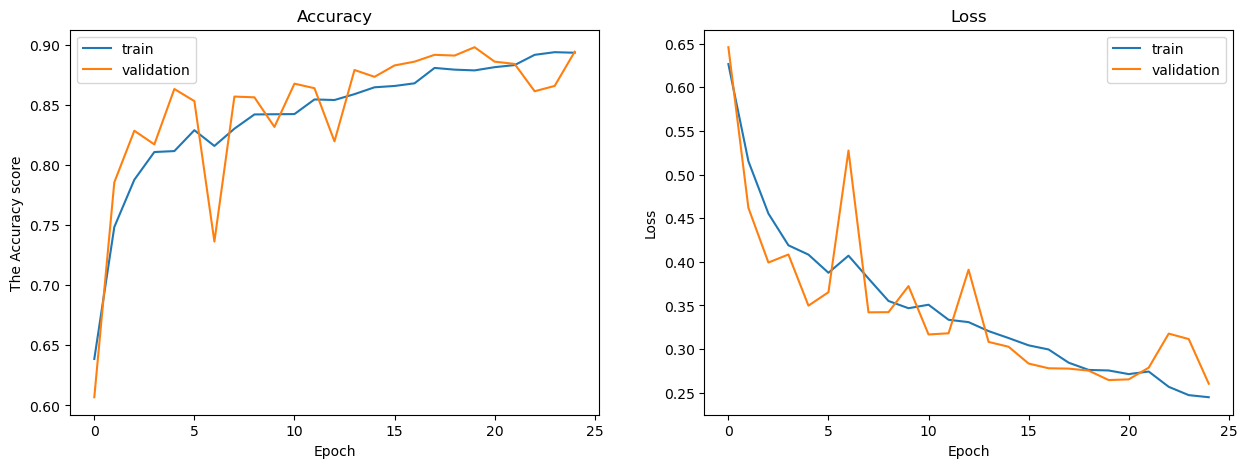

25/25 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step
              precision    recall  f1-score   support

      Benign       0.81      0.89      0.84       510
   Malignant       0.94      0.90      0.92      1072

    accuracy                           0.89      1582
   macro avg       0.87      0.89      0.88      1582
weighted avg       0.90      0.89      0.90      1582



2024-08-17 09:49:34.455898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Axes: >

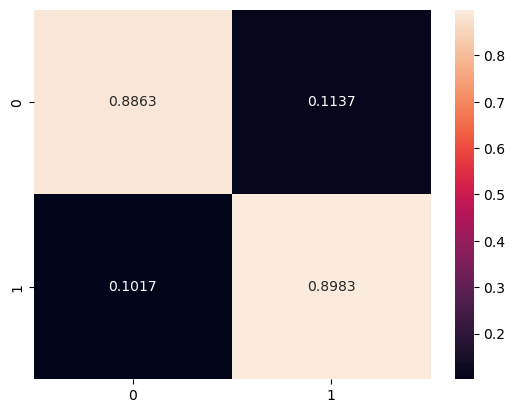

In [33]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
history = model.fit(X_trainset, epochs=25, verbose=1, validation_data=X_testset, callbacks=[earlystopping], class_weight=class_weights)
score = model.evaluate(X_testset)
plotTrainingHistory(history)
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)
print(classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]))
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

# Plotting the Receiver Operating Characteristic (ROC) Curve and Calculating AUC

*model.predict(X_testset), this function generates the predicted probabilities for each class for the samples in the test set (X_testset).* <br> *y_test_pred_prob, this variable stores the predicted probabilities for both classes.* <br> *np.concatenate([y for x, y in X_testset]), this function is used to concatenate the true labels for all the samples in the test set into a single array that is true_categories.* <br>
*y_test_pred_prob_class1 = y_test_pred_prob[:, 1]:y_test_pred_prob[:, 1], this line extracts the predicted probabilities for class 1 that is "Malignant" from the y_test_pred_prob array. These probabilities are used to compute the ROC curve.* <br> *roc_curve, this function computes the False Positive Rate (FPR) and True Positive Rate (TPR) at various threshold settings.* <br> <br> *FPR: The proportion of negative samples that were incorrectly classified as positive.* <br> *TPR (Sensitivity or Recall): The proportion of positive samples that were correctly classified as positive.* <br> <br> *The ROC curve plots TPR against FPR for different threshold values.* <br>
*roc_auc = auc(fpr, tpr):auc(fpr, tpr), this line calculates the Area Under the ROC Curve (AUC). The AUC is a single scalar value that summarizes the performance of the model across all threshold values.* <br> *roc_auc, the AUC value, which ranges from 0 to 1. A value closer to 1 indicates better model performance. Here the AUC value is 0.94, which conveys that the model is working extreamly well.*

25/25 ━━━━━━━━━━━━━━━━━━━━ 206s 8s/step


2024-08-17 09:53:02.836073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


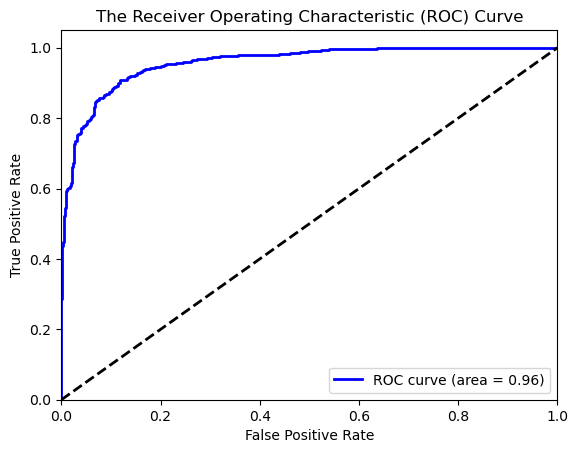

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_pred_prob = model.predict(X_testset)

true_categories = np.concatenate([y for x, y in X_testset])
y_test_pred_prob_class1 = y_test_pred_prob[:, 1]

fpr, tpr, _ = roc_curve(true_categories, y_test_pred_prob_class1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue', lw=lw, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Plotting the Percentage of Correctly Classified Images by Class

*The plotScoresHist function visualizes the percentage of correctly classified images for each class based on the confusion matrix.* <br> *The function calculates the percentage of correctly classified instances for each class and then plots these percentages as a bar chart.*
*The resulting bar chart helps to easily compare how well the model is performing for each class, highlighting any discrepancies in classification accuracy between benign and malignant classes.*

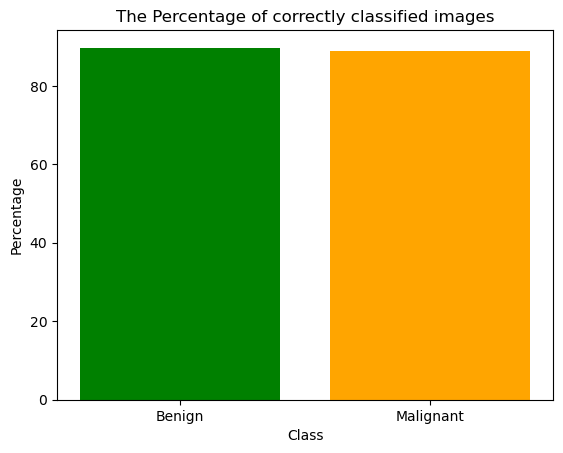

In [39]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("The Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)


# Confusion Matrix without Normalization

In [40]:
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = np.concatenate([y for x, y in X_testset], axis=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 216s 9s/step


2024-08-17 09:56:41.321261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
cm = confusion_matrix(true_categories, predicted_categories)

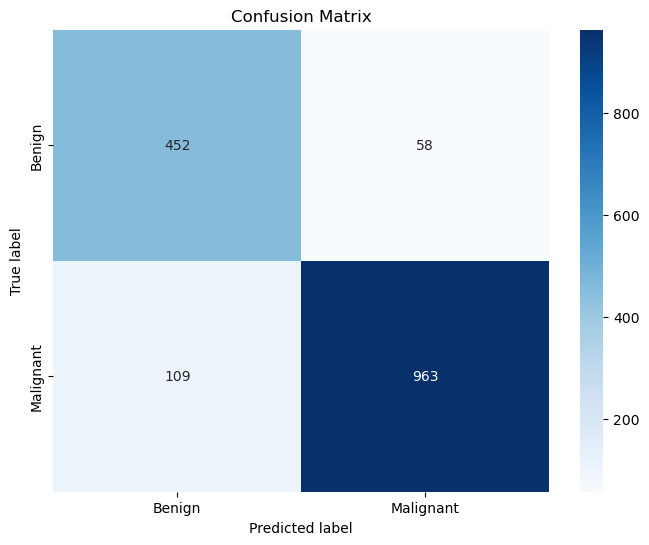

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()